# XLM-ROBERTA Fine Tuning Pipeline
This notebook automates the fine tuning of NLP model XLM-ROBERTA


## Setup & Imports


In [1]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import re
import string
from transformers.trainer_utils import get_last_checkpoint
from torch.nn import CrossEntropyLoss

## Configurations


In [3]:
DATA_PATHS = [
  "../../data/nlp/tweet_emotions.csv",
  "../../data/nlp/Sentiment-analysis-for-mental-health.csv"
]
MODEL_NAME = "xlm-roberta-base"
# "distilbert-base-multilingual-cased"
# "xlm-roberta-base"

MODEL_PATH_FINETUNE_1 = "../../models/nlp/sentiment_finetune_1"
MODEL_PATH_MODEL_1 = "../../models/nlp/sentiment_model_1"

MODEL_PATH_FINETUNE_2 = "../../models/nlp/sentiment_finetune_2"
MODEL_PATH_MODEL_2 = "../../models/nlp/sentiment_model_2"


## Load Data

In [4]:
dataset_1_broad_emotion = load_dataset("csv", data_files=DATA_PATHS[0])
dataset_2_specialize = load_dataset("csv", data_files=DATA_PATHS[1])

# Rename
dataset_1_broad_emotion = dataset_1_broad_emotion.rename_column("sentiment", "labels")
dataset_1_broad_emotion = dataset_1_broad_emotion.rename_column("content", "text")

dataset_2_specialize = dataset_2_specialize.rename_column("status", "labels")
dataset_2_specialize = dataset_2_specialize.rename_column("statement", "text")

# Remove unwanted column
dataset_1_broad_emotion = dataset_1_broad_emotion.remove_columns(["tweet_id"])
dataset_2_specialize = dataset_2_specialize.remove_columns(["Unnamed: 0"])

print("\nDataset: tweet_emotions")
print(dataset_1_broad_emotion)
print("Dataset: Sentiment-analysis-for-mental-health")
print(dataset_2_specialize)



Dataset: tweet_emotions
DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 40000
    })
})
Dataset: Sentiment-analysis-for-mental-health
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 53043
    })
})


## Data Pre-processing & Visualization


### Check unique labels



#### labels visualization


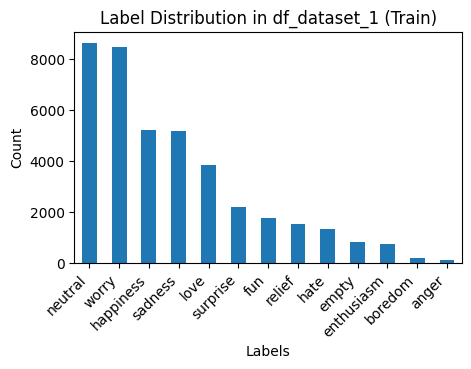

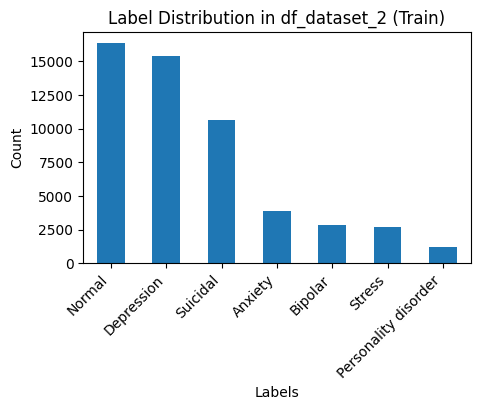

In [5]:
def label_visualization():
  # Convert data to pandas dataframe for visualization
  df_dataset_1 = dataset_1_broad_emotion["train"].to_pandas()
  df_dataset_2 = dataset_2_specialize["train"].to_pandas()

  # Count label frequencies
  label_for_df1_counts = df_dataset_1["labels"].value_counts()
  label_for_df2_counts = df_dataset_2["labels"].value_counts()

  # Plot distribution for df_dataset_1
  plt.figure(figsize=(5, 3))
  label_for_df1_counts.plot(kind="bar")
  plt.xticks(rotation=45, ha="right")
  plt.title("Label Distribution in df_dataset_1 (Train)")
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.show()

  # Plot distribution for df_dataset_2
  plt.figure(figsize=(5, 3))
  label_for_df2_counts.plot(kind="bar")
  plt.xticks(rotation=45, ha="right")
  plt.title("Label Distribution in df_dataset_2 (Train)")
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.show()

label_visualization()

#### label pre-process

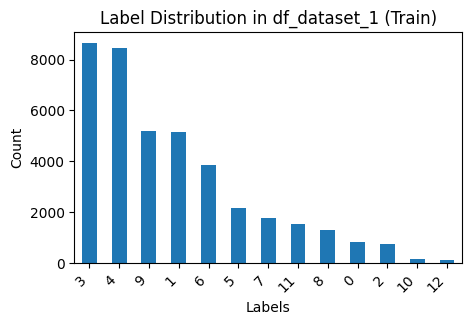

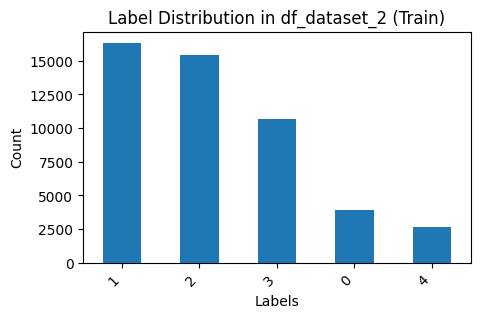

In [6]:
# Get unique labels
labels_1 = dataset_1_broad_emotion["train"].unique("labels")
label_1_to_id = {l: i for i, l in enumerate(labels_1)}
id_1_to_label = {i: l for l, i in label_1_to_id.items()}

labels_2 = dataset_2_specialize["train"].unique("labels")
label_2_to_id = {l: i for i, l in enumerate(labels_2)}
id_2_to_label = {i: l for l, i in label_2_to_id.items()}

# Based on the graphs above i don't want "Bipolar", "Personality disorder"
unwanted_labels = ["Bipolar", "Personality disorder"]
dataset_2_specialize["train"] = dataset_2_specialize["train"].filter(
    lambda example: example["labels"] not in unwanted_labels
)

def make_label_encoder(label_to_id: dict, column_name: str = "labels"):
    """Returns a function that encodes labels for the given column using label_to_id mapping."""
    def encode_labels(example):
        example[column_name] = label_to_id[example[column_name]]
        return example
    return encode_labels

encoder_for_data1 = make_label_encoder(label_1_to_id, column_name="labels")
encoder_for_data2 = make_label_encoder(label_2_to_id, column_name="labels")

dataset_1_broad_emotion = dataset_1_broad_emotion.map(encoder_for_data1)
dataset_2_specialize = dataset_2_specialize.map(encoder_for_data2)

# Re check if changes were applied correctly
label_visualization()


### Check for rows that has null or blank values

In [7]:
def check_for_null_blank(dataset, dataset_name="Dataset"):
    import pandas as pd

    # If it's a DatasetDict, loop over splits
    if hasattr(dataset, "keys"):  # DatasetDict
        for split in dataset.keys():
            print(f"Checking split: {split} in {dataset_name}\n")
            df = dataset[split].to_pandas()
            
            # Nulls
            print("Nulls in each column:")
            print(df[["text", "labels"]].isnull().sum())
            print("\n")
            
            # Rows with nulls
            print("Rows where text or labels are null/blank:")
            print(df[df["text"].isnull() | df["labels"].isnull()])
            print("\n")
            
            # Blank strings
            print("Check for blank and empty string values:")
            print("Blank texts:", (df["text"].str.strip() == "").sum())
            print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
            print("\n")
    else:  # Single Dataset
        df = dataset.to_pandas()
        print(f"Checking {dataset_name}\n")
        print("Nulls in each column:")
        print(df[["text", "labels"]].isnull().sum())
        print("\n")
        print("Rows where text or labels are null/blank:")
        print(df[df["text"].isnull() | df["labels"].isnull()])
        print("\n")
        print("Check for blank and empty string values:")
        print("Blank texts:", (df["text"].str.strip() == "").sum())
        print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
        print("\n")

check_for_null_blank(dataset_1_broad_emotion, "Dataset 1")
check_for_null_blank(dataset_2_specialize, "Dataset 2")


Checking split: train in Dataset 1

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [labels, text]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0


Checking split: train in Dataset 2

Nulls in each column:
text      138
labels      0
dtype: int64


Rows where text or labels are null/blank:
       text  labels
293    None       0
572    None       0
595    None       0
1539   None       1
2448   None       1
...     ...     ...
48760  None       0
48792  None       0
48858  None       0
48932  None       0
48953  None       0

[138 rows x 2 columns]


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0




### Drop rows that has null / blank / empty string values

In [8]:
# Drop rows where statement or status is null
def drop_nulls_from_dataset(dataset, columns=["text", "labels"]):
    """
    Drops null and blank values from a Dataset or DatasetDict.
    Works for both cases.
    """
    if isinstance(dataset, DatasetDict):  # Case 1: DatasetDict with train/test
        cleaned_splits = {}
        for split_name, ds_split in dataset.items():
            df = ds_split.to_pandas()
            df = df.dropna(subset=columns)
            if "text" in columns:
                df = df[df["text"].str.strip() != ""]
            cleaned_splits[split_name] = Dataset.from_pandas(df)
            print(f"✅ Cleaned {split_name}: {len(ds_split)} → {len(df)} rows")
        return DatasetDict(cleaned_splits)

    elif isinstance(dataset, Dataset):  # Case 2: Single Dataset
        df = dataset.to_pandas()
        df = df.dropna(subset=columns)
        if "text" in columns:
            df = df[df["text"].str.strip() != ""]
        cleaned_dataset = Dataset.from_pandas(df)
        print(f"✅ Cleaned dataset: {len(dataset)} → {len(df)} rows")
        return cleaned_dataset

    else:
        raise TypeError("Expected Dataset or DatasetDict")

dataset_1_broad_emotion = drop_nulls_from_dataset(dataset_1_broad_emotion)
dataset_2_specialize = drop_nulls_from_dataset(dataset_2_specialize)

# Check counts again
check_for_null_blank(dataset_1_broad_emotion);
check_for_null_blank(dataset_2_specialize);

✅ Cleaned train: 40000 → 40000 rows
✅ Cleaned train: 48965 → 48827 rows
Checking split: train in Dataset

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [labels, text]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0


Checking split: train in Dataset

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels, __index_level_0__]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0




### Remove special characters

In [9]:
def clean_text(example):
    text = example["text"]  # assumes your dataset column is named 'text'
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove newlines and other non-word characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return {"text": text}

dataset_1_broad_emotion = dataset_1_broad_emotion.map(clean_text)
dataset_2_specialize = dataset_2_specialize.map(clean_text)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/48827 [00:00<?, ? examples/s]

### Check thhe max length the text column contains

In [116]:
def get_min_max_len(example):
  lengths = example["train"].to_pandas()['text'].str.len()

  max_length = lengths.max()
  min_length = lengths.min()
  short_texts_count = (lengths <= min_length).sum()
  long_texts_count = (lengths >= max_length).sum()

  print(f"Max: {max_length}")
  print(f"Min: {min_length}")
  print(f'Short text count: {short_texts_count}')
  print(f'Long text count: {long_texts_count}')

print("Dataset 1")
get_min_max_len(dataset_1_broad_emotion)
print('\nDataset 2')
get_min_max_len(dataset_2_specialize)

Dataset 1
Max: 151
Min: 0
Short text count: 4
Long text count: 1

Dataset 2
Max: 31499
Min: 0
Short text count: 7
Long text count: 1


### Split training data to validation to test

In [10]:
dataset_1_broad_emotion = dataset_1_broad_emotion["train"].train_test_split(test_size=0.2) 
dataset_2_specialize = dataset_2_specialize["train"].train_test_split(test_size=0.2)

# Original split: train / test
original_train_1 = dataset_1_broad_emotion["train"]
original_test_1 = dataset_1_broad_emotion["test"]

original_train_2 = dataset_2_specialize["train"]
original_test_2 = dataset_2_specialize["test"]

# Split train into train + validation (e.g., 80% train, 20% validation)
train_valid_split_1 = original_train_1.train_test_split(test_size=0.2)
train_valid_split_2 = original_train_2.train_test_split(test_size=0.2)

dataset_1_broad_emotion = DatasetDict({
    "train": train_valid_split_1["train"],
    "validation": train_valid_split_1["test"],
    "test": original_test_1
})

dataset_2_specialize = DatasetDict({
    "train": train_valid_split_2["train"],
    "validation": train_valid_split_2["test"],
    "test": original_test_2
})

print(dataset_1_broad_emotion)
print(dataset_2_specialize)

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 25600
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 8000
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 31248
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 7813
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 9766
    })
})


## Model Training / Fine Tuning


### Load Tokenizer + Model

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(labels_2), id2label=id_2_to_label, label2id=label_2_to_id
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Check to know what token max length to use

Train Set words stats:
Max length: 5214
Min length: 0


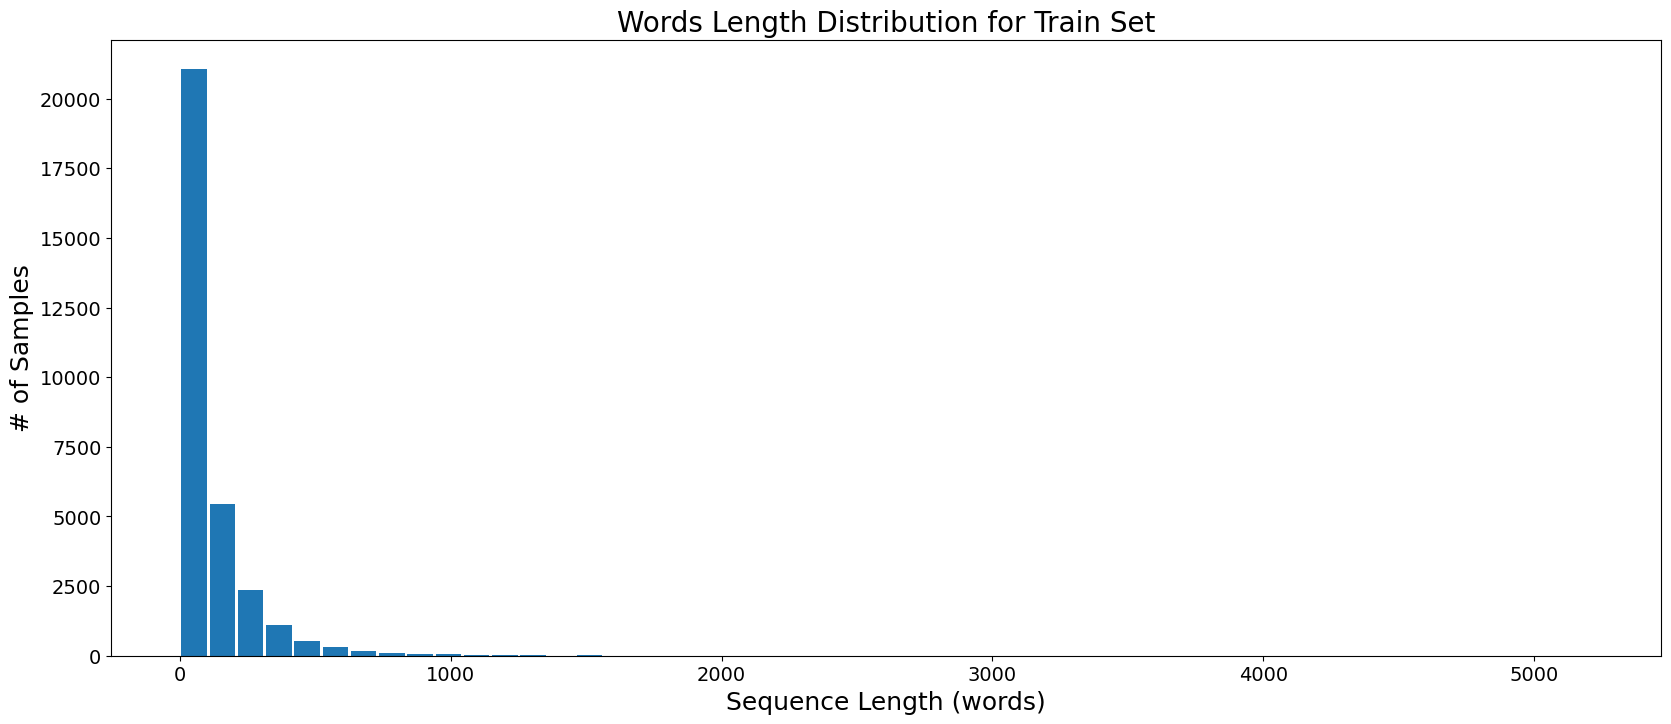

Train Set words stats:
Max length: 6300
Min length: 1


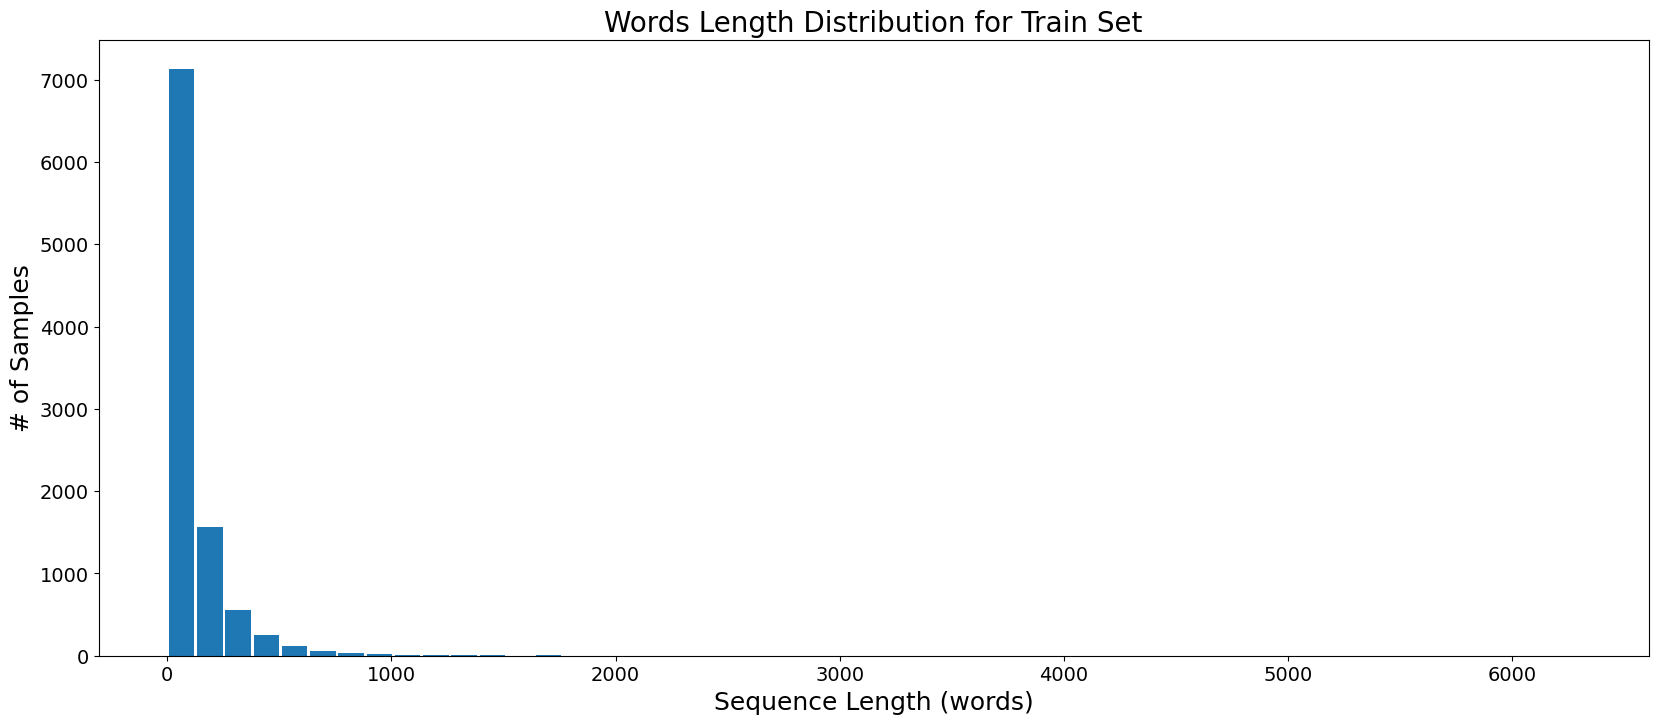

In [ ]:
def plot_token_length_distribution(dataset, text_column='text', dataset_name="Dataset"):
    """
    Plots the distribution of sentence lengths or token lengths.
    
    Args:
        dataset: Hugging Face Dataset (tokenized or raw).
        text_column: Name of the column to measure length on. 
                     Use 'text' for raw strings or 'input_ids' for tokenized lists.
        dataset_name: Optional name for labeling the plot.
    """
    # Check first row type to decide how to measure length
    first_elem = dataset[0][text_column]
    
    if isinstance(first_elem, list):  # tokenized
        lengths = [len(x) for x in dataset[text_column]]
        unit = "tokens"
    elif isinstance(first_elem, str):  # raw text
        lengths = [len(x.split()) for x in dataset[text_column]]  # measure words
        unit = "words"
    else:
        raise ValueError(f"Column {text_column} has unsupported type: {type(first_elem)}")
    
    print(f"{dataset_name} {unit} stats:")
    print('Max length:', max(lengths))
    print('Min length:', min(lengths))
    
    plt.figure(figsize=(10, 4))
    plt.hist(lengths, bins=50, rwidth=0.9)
    plt.xlabel(f'Sequence Length ({unit})', fontsize=18)
    plt.ylabel('# of Samples', fontsize=18)
    plt.title(f'{unit.capitalize()} Length Distribution for {dataset_name}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# Raw dataset
plot_token_length_distribution(dataset_2_specialize["train"], text_column='text', dataset_name="Train Set")
plot_token_length_distribution(dataset_2_specialize["test"], text_column='text', dataset_name="Train Set")

### Tokenize

In [14]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

dataset_1_broad_emotion = dataset_2_specialize.map(tokenize_function, batched=True)

print(torch.cuda.is_available())  # should be True
print(torch.cuda.get_device_name(0))  # should show RTX 3060

Map:   0%|          | 0/31248 [00:00<?, ? examples/s]

Map:   0%|          | 0/7813 [00:00<?, ? examples/s]

Map:   0%|          | 0/9766 [00:00<?, ? examples/s]

True
NVIDIA GeForce RTX 3060


### Use weighted loss for imbalance

In [ ]:
# class FocalLoss(torch.nn.Module):
#     def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, logits, targets):
#         ce_loss = torch.nn.functional.cross_entropy(logits, targets, weight=self.alpha, reduction='none')
#         pt = torch.exp(-ce_loss)
#         loss = ((1 - pt) ** self.gamma) * ce_loss
#         if self.reduction == 'mean':
#             return loss.mean()
#         elif self.reduction == 'sum':
#             return loss.sum()
#         return loss


# labels = np.array(dataset_1_broad_emotion["train"]["labels"])
# class_counts = np.bincount(labels)
# class_weights = 1.0 / class_counts
# class_weights = class_weights / class_weights.sum() * len(class_counts)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(model.device)

# class WeightedTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
#         labels = inputs.get("labels")
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
#         labels = labels.to(logits.device)
#         loss_fct = FocalLoss(alpha=class_weights.to(logits.device))
#         loss = loss_fct(logits, labels)
#         return (loss, outputs) if return_outputs else loss

### Train on Dataset (1)

In [17]:
# Set format for PyTorch
dataset_1_broad_emotion.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)
    f1_score = f1.compute(predictions=preds, references=p.label_ids, average="macro")
    
    return {**acc, **f1_score}

training_args = TrainingArguments(
    output_dir=MODEL_PATH_FINETUNE_1,

    # Evaluation & saving
    eval_strategy="steps",             # evaluate more frequently
    eval_steps=500,                    # evaluate every 500 steps
    save_strategy="steps",             # save every eval
    save_steps=500,
    save_total_limit=3,                # keep last 3 checkpoints

    # Optimizer
    learning_rate=2e-5,
    warmup_ratio=0.1,                  # 10% warmup               
    weight_decay=0.05,                 # helps reduce overfitting

    # Batch size
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,     # effective batch size 16

    # Mixed precision
    fp16=True,                         # faster training

    # Training length
    num_train_epochs=5,                # shorter to prevent overfitting
    load_best_model_at_end=True,       # load checkpoint with best validation loss
    metric_for_best_model="f1",  # choose metric to track best model

    # Misc
    dataloader_num_workers=4,
    # logging_steps=100,                 # logs every 100 steps
    # logging_dir=f"{MODEL_PATH_FINETUNE_1}/logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_1_broad_emotion["train"],
    eval_dataset=dataset_1_broad_emotion["validation"],  # <-- use validation here
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

last_checkpoint = get_last_checkpoint(MODEL_PATH_FINETUNE_1)

trainer.train(resume_from_checkpoint=last_checkpoint)

C:\Users\PC\AppData\Local\Temp\ipykernel_24932\1251425280.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
500,1.311300,0.819574,0.680916,0.538352
1000,0.683300,0.546934,0.778062,0.738692
1500,0.589200,0.586995,0.793037,0.760131
2000,0.540300,0.496498,0.806988,0.773157
2500,0.468100,0.479944,0.807372,0.776017
3000,0.460500,0.503425,0.803149,0.778765
3500,0.459600,0.478173,0.813772,0.791923
4000,0.435300,0.449684,0.822731,0.801370
4500,0.371900,0.484052,0.817228,0.795823
5000,0.372400,0.449487,0.824267,0.805220


TrainOutput(global_step=9765, training_loss=0.429996100219164, metrics={'train_runtime': 3644.2275, 'train_samples_per_second': 42.873, 'train_steps_per_second': 2.68, 'total_flos': 2.0555158385664e+16, 'train_loss': 0.429996100219164, 'epoch': 5.0})

### Save Checkpoint

In [ ]:
model.save_pretrained(MODEL_PATH_MODEL_1)
tokenizer.save_pretrained(MODEL_PATH_MODEL_1)

('../../models/nlp/sentiment_model_1\\tokenizer_config.json',
 '../../models/nlp/sentiment_model_1\\special_tokens_map.json',
 '../../models/nlp/sentiment_model_1\\vocab.txt',
 '../../models/nlp/sentiment_model_1\\added_tokens.json',
 '../../models/nlp/sentiment_model_1\\tokenizer.json')